In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import Data

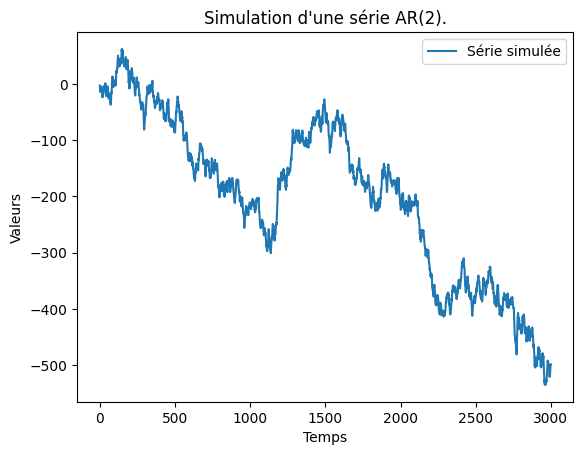

In [2]:
y = data_simulation(phi1=1.3, phi2=-0.3, trend=0.0, change=False, sigma=4, n= 3000)
simple_plot(y)


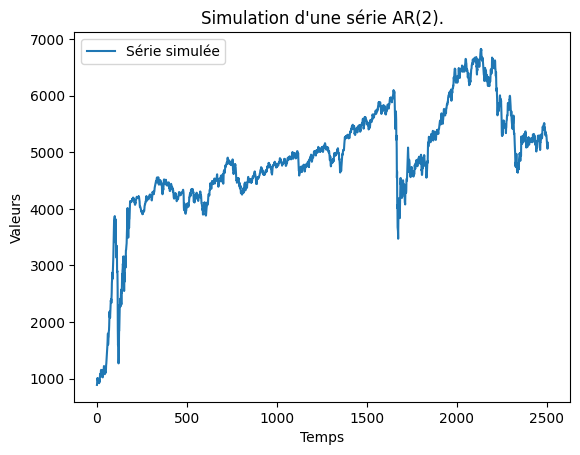

In [75]:
df = pd.read_csv('./data/GANData.csv')
simple_plot(df[df['ASSETNAME']=="Global Property USD Unhedged"]['PRICE'])

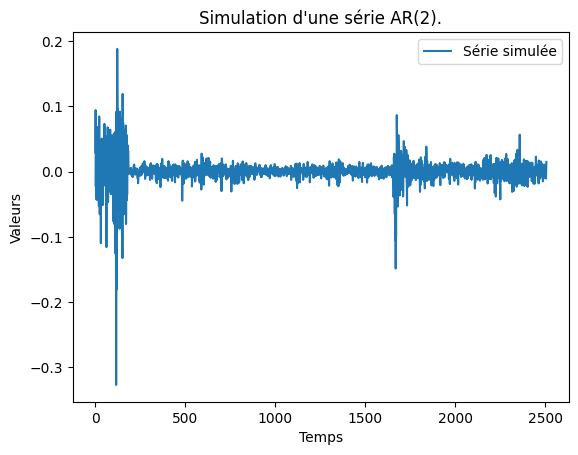

In [80]:
sdf = df[df['ASSETNAME']=="Global Property USD Unhedged"]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
simple_plot(y)

In [81]:
y.shape

(2506,)

In [82]:
latent_dim = 20
ts_dim = 50
conditional = 10

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-4
lr_b = 1e-4
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = 1e-4, max_lr= 8e-4, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = 1e-4, max_lr= 6e-4, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 5000
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

True


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 84%|████████▍ | 4199/5000 [53:07<09:53,  1.35it/s] /home/onyxia/work/statapp-hsbc/utils/data.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2,2,figsize=(10, 10))
100%|██████████| 5000/5000 [1:03:02<00:00,  1.32it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [10]:
train.losses.keys()

dict_keys(['G', 'D', 'GP', 'gradient_norm', 'LR_G', 'LR_D'])

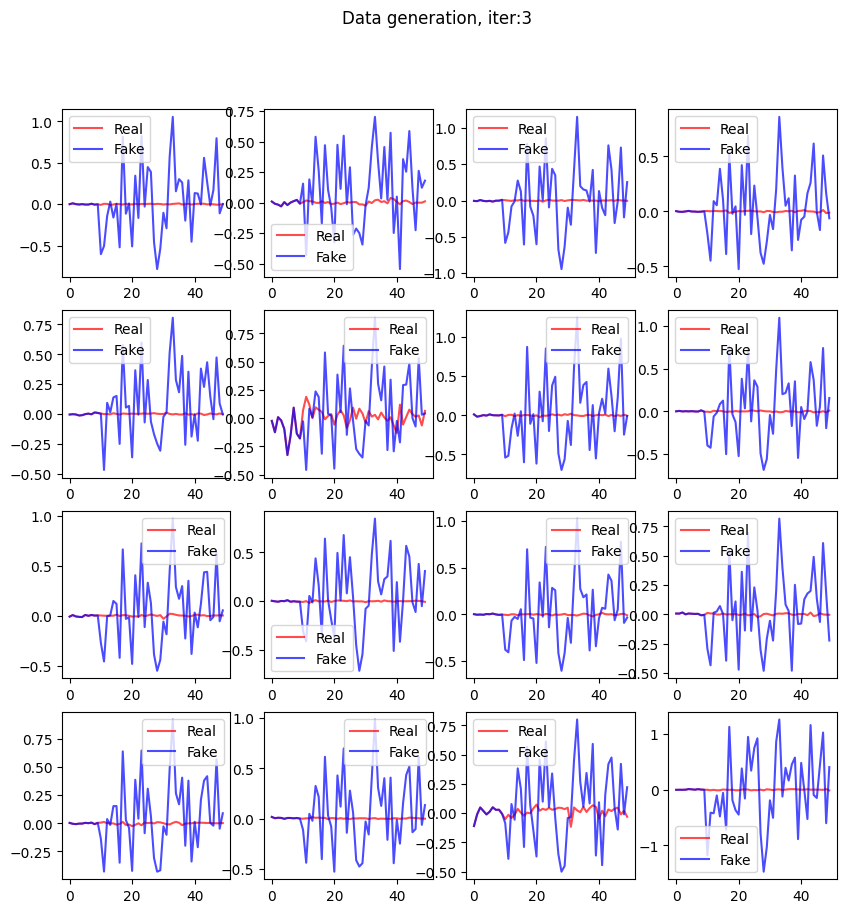

In [255]:
def show_examples(real, fake, size=2):
    real = np.squeeze(real)
    fake = np.squeeze(fake)

    fig, ax = plt.subplots(size,size,figsize=(10, 10))
    ax = ax.flatten()
    fig.suptitle('Data generation, iter:' +str(3))
    for i in range(ax.shape[0]):
        ax[i].plot(real[i], color='red', label='Real', alpha =0.7)
        ax[i].plot(fake[i], color='blue', label='Fake', alpha =0.7)
        ax[i].legend()

    plt.show()

show_examples(train.real_lines, train.fake_lines, size=4)

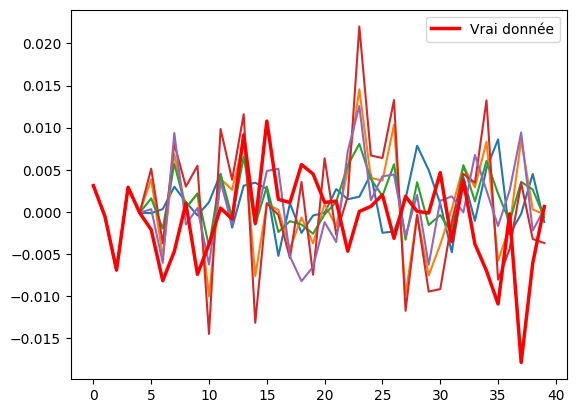

In [204]:
def generate_fake_lines(input_, train, num):
    for i in range(num):
        conditional = 5
        noise = torch.randn((1, 1, train.latent_dim))
        #noise = test
        real_samples = torch.from_numpy(input_[:conditional])
        noise[0][0][:conditional] = real_samples[:conditional]
        noise = noise.cuda()
        v = train.G(noise)/100
        v[0][0][:conditional] = real_samples[:conditional]
        fake_line = np.array(v.float().cpu().detach()[0][0])
        plt.plot(fake_line)
    plt.plot(input_[:len(fake_line)], label=f'Vrai donnée', linewidth=2.5, color="red")
    plt.legend()
    plt.show()
generate_fake_lines(y[200:],train, 5)

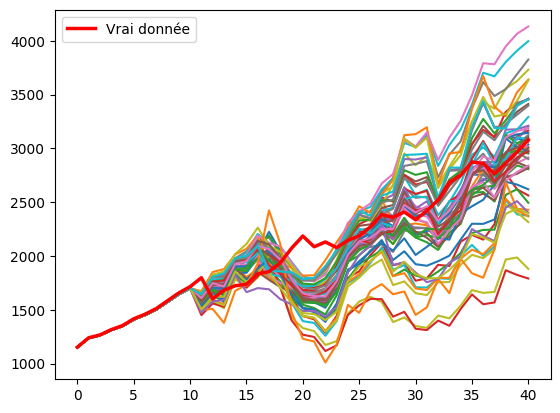

In [252]:
def generate_fake_scenario(input_, true_input,train, num):
    for i in range(num):
        conditional = train.conditional
        noise = torch.randn((1, 1, train.latent_dim))
        #noise = test
        real_samples = torch.from_numpy(input_[:conditional])
        noise[0][0][:conditional] = real_samples[:conditional]
        noise = noise.cuda()
        v = train.G(noise)/5
        v[0][0][:conditional] = real_samples[:conditional]
        croissance = np.array(v.float().cpu().detach()[0][0])
        fake_line = np.array([true_input[0]] + [true_input[0] * np.prod(1 + croissance[:i+1]) for i in range(40)])
        plt.plot(fake_line)
    plt.plot(true_input[:len(fake_line)], label=f'Vrai donnée', linewidth=2.5, color="red") 
    plt.legend()
    plt.show()
start = 50
generate_fake_scenario(y[start:],true_y.to_numpy()[start:],train, 50)